In [75]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
%pip install pmdarima -q
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

Note: you may need to restart the kernel to use updated packages.


In [76]:
df = pd.read_csv('D:\\bachelor\\dataset_resampled.csv')
print(df.head())

  utc_timestamp  DE_KN_residential4_grid_import  \
0    2015-10-10                        1.837840   
1    2015-10-11                        5.083840   
2    2015-10-12                        9.824345   
3    2015-10-13                       14.717635   
4    2015-10-14                       27.373166   

   DE_KN_residential4_grid_export      temp  holiday  season_Autumn  \
0                        0.000000  7.918333      0.0            1.0   
1                        3.193533  6.505729      0.0            1.0   
2                       21.286176  5.033854      0.0            1.0   
3                       39.081159  3.545833      0.0            1.0   
4                       46.060247  3.981771      0.0            1.0   

   season_Spring  season_Summer  season_Winter  day_of_week_Friday  \
0            0.0            0.0            0.0                 0.0   
1            0.0            0.0            0.0                 0.0   
2            0.0            0.0            0.0          

In [77]:
# Convert 'utc_timestamp' to datetime format if it's not already
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])

# Convert 'utc_timestamp' to ordinal date (number of days since a certain date)
df['utc_timestamp'] = df['utc_timestamp'].apply(lambda x: x.toordinal())

In [78]:
# Define the endogenous variable (the variable we want to predict)
endog = df['DE_KN_residential4_grid_import']

# Define the exogenous variables (the variables we use to predict the endogenous variable)
exog = df.drop(['DE_KN_residential4_grid_import', 'DE_KN_residential4_grid_export'], axis=1)

In [79]:
# Define the model
model = ARIMA(endog, order=(1, 1, 1), exog=exog)

# Fit the model
model_fit = model.fit()

c:\Users\wavad\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [80]:
# # Fit the SARIMAX model
# SARIMAX_model = pm.auto_arima(endog, exogenous=exog,
#                               start_p=1, start_q=1,
#                               test='adf',
#                               max_p=3, max_q=3, m=12,
#                               start_P=0, seasonal=True,
#                               d=None, D=1, trace=False,
#                               error_action='ignore',
#                               suppress_warnings=True,
#                               stepwise=True)

In [81]:
def sarimax_forecast(train, test, order, seasonal_order, exog_train, exog_test, train_target):
    model = SARIMAX(train_target, order=order, seasonal_order=seasonal_order, exog=exog_train)
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, exog=exog_test)
    return predictions


In [82]:
# Split the data
train = df[:-7]
test = df[-7:]
exog_train = train[['temp', 'season_Autumn', 'season_Spring', 'season_Summer', 'season_Winter']]
exog_test = test[['temp', 'season_Autumn', 'season_Spring', 'season_Summer', 'season_Winter']]

train_target = train['DE_KN_residential4_grid_import']
test_target = test['DE_KN_residential4_grid_import']

# Define the order and seasonal_order parameters
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

# Call the function
predictions = sarimax_forecast(train, test, order, seasonal_order, exog_train, exog_test, train_target)
predictions.index = test_target.index  # Set the index of the predictions to match the test_target index

c:\Users\wavad\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [83]:
# And `y_test` are the true values
mae = mean_absolute_error(test['DE_KN_residential4_grid_import'], predictions)

print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 6.814404320717325


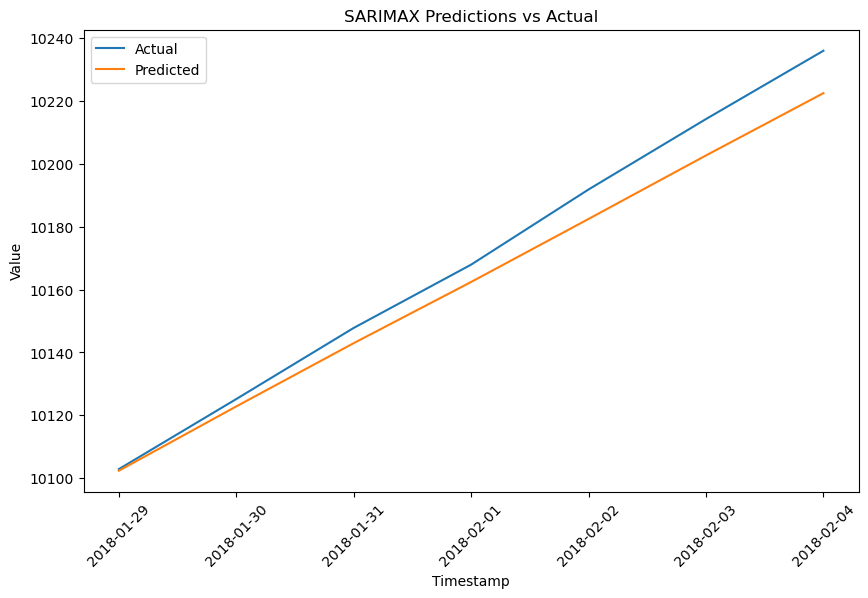

In [84]:
# Assuming 'dates' is your list of dates and 'predictions' is your list of predicted values
dates = pd.date_range(end='02-04-2018', periods=len(predictions), freq='d')
# Plot
plt.figure(figsize=(10,6))
plt.plot(dates, test_target, label='Actual')
plt.plot(dates, predictions, label='Predicted')
plt.title('SARIMAX Predictions vs Actual')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.legend(loc='best')
plt.show()

In [85]:
# Fit the model
model_fit = model.fit()

# Use a method of the 'ARIMA' class
model_fit.summary()

c:\Users\wavad\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:     DE_KN_residential4_grid_import   No. Observations:                  849
Model:                             ARIMA(1, 1, 1)   Log Likelihood               -2126.204
Date:                            Wed, 22 May 2024   AIC                           4286.407
Time:                                    16:31:02   BIC                           4367.036
Sample:                                         0   HQIC                          4317.296
                                            - 849                                         
Covariance Type:                              opg                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
utc_timestamp            -0.0130      2.577     -0.005      0.996      -5.063       5.037
temp                      0.0764      0.040      1.919      0.055      -0.002       0.154
holiday                1.993e-15   1.08e-14      0.185      0.853   -1.91e-14    2.31e-14
season_Autumn             0.4609      1.292      0.357      0.721      -2.072       2.994
season_Spring             0.7059      1.712      0.412      0.680      -2.649       4.061
season_Summer            -0.1787      2.299     -0.078      0.938      -4.684       4.327
season_Winter            -0.9882      1.221     -0.809      0.418      -3.382       1.405
day_of_week_Friday       -0.5264      0.197     -2.672      0.008      -0.913      -0.140
day_of_week_Monday        0.4609      0.202      2.279      0.023       0.065       0.857
day_of_week_Saturday     -0.4748      0.185     -2.566      0.010      -0.838      -0.112
day_of_week_Sunday        0.2824      0.179      1.578      0.114      -0.068       0.633
day_of_week_Thursday     -0.2401      0.217     -1.106      0.269      -0.666       0.186
day_of_week_Tuesday       0.2701      0.209      1.291      0.197      -0.140       0.680
day_of_week_Wednesday     0.2159      0.206      1.050      0.294      -0.187       0.619
ar.L1                     0.9896      0.005    205.582      0.000       0.980       0.999
ma.L1                    -0.2372      0.023    -10.400      0.000      -0.282      -0.193
sigma2                    8.7819      0.254     34.547      0.000       8.284       9.280
===================================================================================
Ljung-Box (L1) (Q):                   3.53   Jarque-Bera (JB):               810.25
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             0.31
Prob(H) (two-sided):                  0.61   Kurtosis:                         7.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.66e+18. Standard errors may be unstable.
"""